In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import pandas as pd
import numpy as np
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import sklearn
from itertools import permutations
from pprint import pprint
from PIL import Image
import PIL
import pyodbc
from tqdm import tqdm
from random import random
import math
import seaborn as sns
from matplotlib.lines import Line2D
from torchsummary import summary


In [82]:
plt.ion()   # interactive mode
testimages = list()
testclasses = list()
testindices = list()
testinitialized = 0
PATH = './test_net2b.tar'
ndepth = 3
nminibatchsize = 4
classes = ('Hospitalized','Intubated','Deceased','Pneumonia')
columns = ['Male','Pregnant','Diabetes','Asthma','Immunocompromised'
            ,'Hypertension','Other Disease','Cardiovascular Disease','Obesity','Kidney Disease'
            ,'Tobacco Use','COPD']
nclasses = len(classes)
ncolumns = len(columns)
testratio = 0.2 #randomly select this proportion of the dataset to be test data

In [3]:
nfeatures = 1.0
for i in range(ndepth):
    nfeatures *= (ncolumns - i)
nimgsize = math.ceil(nfeatures**0.5)
npix = nimgsize**2
nagepix = npix - nfeatures
if nagepix < 100:
    nimgsize += 1
    npix = nimgsize**2
    nagepix = npix - nfeatures
normtuple = list()
for i in range(ndepth): normtuple.extend([0.5])
normtuple = tuple(normtuple)
brwnpx = list()
for i in range(ndepth): brwnpx.extend([0.5])
linearscale = math.floor((nimgsize-12)/4)

print('total features: %i; image size: %i x %i x %i; available age pixels: %i' % (nfeatures,nimgsize,nimgsize,ndepth,nagepix))
print('image normalization tuple:')
print(normtuple)

total features: 1320; image size: 38 x 38 x 3; available age pixels: 124
image normalization tuple:
(0.5, 0.5, 0.5)


In [4]:
def getlabelval(labeldata):
    retval = np.array(list(labeldata),dtype=np.float32)
    return retval

class CustomError(Exception):
    pass

In [5]:
#create generator function for data acquisition and conversion to torch image format.
#function must return a tuple of form (tensor containing 4 images,tensor containing 4 labels)
#also builds a test set using a quick and dirty random number method.  this will need to be 
#improved to balance both the test and train sets across potential labels.

def nextrow():
    conn = pyodbc.connect('DSN=covid;UID=seh;PWD=Welcome2020!;')
    crsr = conn.cursor()
    crsr.execute("{CALL getpydatav2}")
    rowcnt = 0
    imgs = list()
    labels = list()
    row = [0,1,2]
    idx = 0
    while row:
        while (rowcnt<nminibatchsize):
            try:
                row = crsr.fetchone()
            except:
                conn = pyodbc.connect('DSN=covid;UID=seh;PWD=Welcome2020!;')
                crsr = conn.cursor()
                crsr.execute("{CALL getpydatav2}")
                crsr.skip(idx*nminibatchsize + rowcnt)
                row = crsr.fetchone()
            rowcnt += 1
            if row:
                icol = 0
                irow = 0
                if len(list(row[0])) != ncolumns: raise CustomError('Invalid Input Size: Expected %i, Received %i' % (ncolumns,len(list(row[0]))))
                imgdata = np.zeros((nimgsize,nimgsize,ndepth),dtype=np.float32)

                for px in permutations(list(row[0]),ndepth):
                    thispx = list()
                    for chan in px: thispx.extend([float(chan)])
                    imgdata[icol,irow,:] = thispx
                    irow += 1
                    if (irow > nimgsize - 1):
                        icol += 1
                        irow = 0
                for age in range(int(nagepix)):
                    if age <= int(row[1]) + 1:
                        imgdata[icol,irow,:] = brwnpx
                    else:
                        break
                    irow += 1
                    if (irow > nimgsize - 1):
                        icol += 1
                        irow = 0
                imgtensor = TF.normalize(TF.to_tensor(imgdata),normtuple,normtuple)
                labels.append(getlabelval(row[2]))
                imgs.append(imgtensor)
            else:
                break
        if row:
            if (testinitialized == 0):
                if (random() < testratio):
                    testimages.append(torch.stack(imgs))
                    testclasses.append(torch.tensor(labels))
                    testindices.append(idx)
                else:
                    yield torch.stack(imgs),torch.tensor(labels)
            elif (idx not in testindices):
                yield torch.stack(imgs),torch.tensor(labels)
            rowcnt = 0
            idx += 1
            imgs = list()
            labels = list()
        else:
            break


In [6]:
#create generator function for test set

def gentestdata(startindex = 0):
    for i,clss in enumerate(testclasses[startindex:],startindex):
        yield testimages[i],clss

def gettestdata(idx = 0):
    return testimages[idx],testclasses[idx]

In [119]:
#the net below is built from the CIFAR tutorial in pytorch
#needs major changes to function correctly in this application
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
       
        # 3 input image channels, 6 output channels, 5x5 square convolution
        self.conv1 = nn.Conv2d(ndepth, ncolumns, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(ncolumns, ncolumns*2, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(5400, 578)  
        self.fc2 = nn.Linear(578, 34)
        self.fc3 = nn.Linear(34, nclasses) 

    def forward(self, x):
        x = F.relu(self.conv1(x))
        #print(x.size())
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.size())
        x = x.view(-1, 5400)
        #print(x.size())
        x = F.relu(self.fc1(x))
        #print(x.size())
        x = F.relu(self.fc2(x))
        #print(x.size())
        x = self.fc3(x)
        #print(x.size())
        return F.sigmoid(x)

net = Net()

#loss function and optimizer were set based on CIFAR example also
#need to experiment with different hyperparameters and types
criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)
print((ndepth,nimgsize,nimgsize))
print(summary(net,(ndepth,nimgsize,nimgsize)))

(3, 38, 38)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 34, 34]             912
            Conv2d-2           [-1, 24, 30, 30]           7,224
         MaxPool2d-3           [-1, 24, 15, 15]               0
            Linear-4                  [-1, 578]       3,121,778
            Linear-5                   [-1, 34]          19,686
            Linear-6                    [-1, 4]             140
Total params: 3,149,740
Trainable params: 3,149,740
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 0.32
Params size (MB): 12.02
Estimated Total Size (MB): 12.35
----------------------------------------------------------------
None


In [120]:
#train a new model
validationfreq = 1000

for epoch in range(2):  # loop over the dataset multiple times
    lasttestidx = 0
    running_loss = 0.0
    testcnt = 0
    rowgen = nextrow()
    pbar = tqdm(enumerate(rowgen),total=6798)
    for i, data in pbar:
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        #print((outputs,labels))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        if i % validationfreq == validationfreq - 1:    # print every 100 mini-batches
            #tqdm.write('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 200))
            valid_loss = 0.0
            net.eval()
            with torch.no_grad():
                randomstartindex = math.floor(len(testimages)*random())
                genfunc = gentestdata(randomstartindex)
                for j, (tin,tlab) in enumerate(genfunc):
                    lasttestidx = j + 1
                    outputs = net(tin)
                    loss = criterion(outputs,tlab)
                    valid_loss += loss.item()
                    if j >= 20: break
            pbar.set_description(desc='[%d, %5d] loss: %.3f; validation loss: %.3f; validation count: %i; test start index: %i' 
                                        % (epoch + 1, i + 1, running_loss / validationfreq,valid_loss / lasttestidx,lasttestidx,randomstartindex))
            running_loss = 0.0
            net.train()
        pbar.update()
    testinitialized = 1

#save test set and model state dictionary for loading later without training.
torch.save({'model_state_dict':net.state_dict(),
            'testimages': testimages,
            'testclasses': testclasses,
            'testindices': testindices}, PATH)
print('Finished Training')

[1,  6000] loss: 0.484; validation loss: 0.456; validation count: 21; test start index: 1208:  99%|█████████▉| 6748/6798 [15:26<00:06,  7.29it/s]
[2,  6000] loss: 0.476; validation loss: 0.449; validation count: 21; test start index: 1117:  99%|█████████▉| 6737/6798 [24:54<00:13,  4.51it/s]
Finished Training


In [121]:
def interpretimagetensor(imgtensor):
    ptsdata = list()
    for (bindata,age) in getbindatafromimagetensor(imgtensor):
        ptdata = str(age) + ' yo, '
        for i, val in enumerate(list(bindata)):
            if i == 0:
                if val == '1':
                    ptdata += 'Male, '
                else:
                    ptdata += 'Female, '
            elif val == '1':
                ptdata += columns[i] + ', '
        ptdata = ptdata[:-2]
        ptsdata.append(ptdata)
    return ptsdata

def getbindatafromimagetensor(imgtensor):
    ptsdata = list()
    for case in imgtensor:
        case = case / 2 + 0.5
        case = case.numpy()
        case = np.transpose(case, (1, 2, 0))
        bindata = ''
        for i in range(ndepth): bindata += str(int(case[0,0,i]))
        for i in range(1,ncolumns - ndepth + 1):
            bindata += str(int(case[0,i,ndepth-1]))
        age = 0
        agechkstart = math.floor(nfeatures**0.5)-math.ceil(nagepix**2)
        #print(agechkstart)
        for p1 in case[agechkstart:,:,0]:
            #print(p1)
            for p2 in p1:
                if str(p2) == '0.5':
                    age += 1
        age -= 2
        ptsdata.append((bindata, age))
    return ptsdata


In [9]:
#skip training and load saved model
checkpoint = torch.load(PATH)
net = Net()
net.load_state_dict(checkpoint['model_state_dict'])
testimages = checkpoint['testimages']
testclasses = checkpoint['testclasses']
testindices = checkpoint['testindices']
testinitialized = 1
net.eval()

Net(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=3468, out_features=578, bias=True)
  (fc2): Linear(in_features=578, out_features=34, bias=True)
  (fc3): Linear(in_features=34, out_features=4, bias=True)
)

In [123]:
#test random image from test set
#net.eval()
randomstartindex = math.floor(len(testimages)*random())
print(randomstartindex)
images, labels = gettestdata(randomstartindex)

with torch.no_grad():
    outputs = net(images)
    ptinfo = interpretimagetensor(images)
    for i in range(nminibatchsize):
        actlist = list()
        predlist = list()
        if sum(labels[i]) == 0.:
            actlist.append('none')
        for j in range(nclasses):
            predlist.extend([str(round(100*float(outputs[i,j]),2)) + '% ' + classes[j]])
            if labels[i,j] == 1.: actlist.extend([classes[j]])
        print(ptinfo[i])
        print(predlist)
        print(actlist)
        print()

786
66 yo, Female, Diabetes, Obesity
['51.21% Hospitalized', '11.29% Intubated', '21.54% Deceased', '40.96% Pneumonia']
['Hospitalized']

80 yo, Male, Diabetes, Hypertension, Tobacco Use
['66.16% Hospitalized', '24.43% Intubated', '38.61% Deceased', '53.23% Pneumonia']
['none']

55 yo, Female
['28.81% Hospitalized', '4.16% Intubated', '8.93% Deceased', '23.67% Pneumonia']
['Hospitalized', 'Deceased', 'Pneumonia']

85 yo, Male
['38.85% Hospitalized', '5.87% Intubated', '12.92% Deceased', '30.24% Pneumonia']
['Hospitalized', 'Pneumonia']



In [ ]:
#model results by class
class_correct = list(0. for i in range(6))
class_total = list(0. for i in range(6))
with torch.no_grad():
    genfunc = gentestdata(0)
    for data in genfunc:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(6):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

In [124]:
labelstats = dict()
for c in classes:
    labelstats[c] = {
        "predprobs" : list(),
        "age" : list(),
        "sex" : list(),
        "conditions" : list()
    }

with torch.no_grad():
    genfunc = gentestdata(0)
    for j, (images,labels) in tqdm(enumerate(genfunc,0),total=len(testimages)):
        outputs = net(images)
        outcomes = np.array(outputs)
        ptinfo = interpretimagetensor(images)
        for i, case in enumerate(outcomes):
            for k, lab in enumerate(labels[i]):
                if lab == 1:
                    thisdict = labelstats[classes[k]]
                    thisdict['predprobs'].append(list(case))
                    thisinfo = ptinfo[i].split(', ')
                    thisdict['age'].append(int(thisinfo[0].strip(' yo')))
                    thisdict['sex'].append(thisinfo[1])
                    thisdict['conditions'].append(thisinfo[2:])



100%|██████████| 1761/1761 [00:29<00:00, 60.21it/s]


In [125]:
flatlblstats = {
    "truth" : list(),
    "predprobs" : list(),
    "age" : list(),
    "conditions" : list()
    }

with torch.no_grad():
    genfunc = gentestdata(0)
    for j, (images,labels) in tqdm(enumerate(genfunc,0),total=len(testimages)):
        outputs = net(images)
        outcomes = np.array(outputs)
        ptinfo = interpretimagetensor(images)
        for i, case in enumerate(outcomes):
            flatlblstats['truth'].append([classes[j] for (j,lab) in enumerate(labels[i]) if lab == 1])
            flatlblstats['predprobs'].append(list(case))
            thisinfo = ptinfo[i].split(', ')
            flatlblstats['age'].append(int(thisinfo[0].strip(' yo')))
            if thisinfo[1] == 'Male':
                flatlblstats['conditions'].append(thisinfo[1:])
            else:
                flatlblstats['conditions'].append(thisinfo[2:])



100%|██████████| 1761/1761 [00:30<00:00, 56.93it/s]


In [126]:
predsbyage = {
    'age': list(),
    }
actualbyage = {
    'age': list(),
    }
for c in classes:
    predsbyage[c] = list()
    actualbyage[c] = list()

for i in tqdm(range(100)):
    predsums = np.zeros(nclasses,dtype=np.float32)
    actsums = np.zeros(nclasses,dtype=np.float32)
    #actsums *= 10
    for j,ag in enumerate(flatlblstats['age']):
        if ag == i:
            for k, val in enumerate(flatlblstats['predprobs'][j]):
                predsums[k] += val
            for k, val in enumerate(flatlblstats['truth'][j]):
                actsums[classes.index(val)] += 1
    predsbyage['age'].append(i)
    actualbyage['age'].append(i)
    for j, c in enumerate(classes):
        predsbyage[c].append(predsums[j])
        actualbyage[c].append(actsums[j])



100%|██████████| 100/100 [00:00<00:00, 582.85it/s]


In [128]:
agedistfromactual = dict()
agedistfrompreds = dict()
for c in classes:
    agedistfromactual[c] = list()
    agedistfrompreds[c] = list()
    for i,val in enumerate(actualbyage[c]):
        agedistfromactual[c].extend([i]*int(val))
    for i,val in enumerate(predsbyage[c]):
        agedistfrompreds[c].extend([i]*int(round(val)))


In [138]:
agedf = pd.DataFrame(columns=['age','type','result'])
#agedf.loc[0] = pd.Series({'age':0,'type':'Predicted','result':'Deceased'})
runi = 0
for c in classes:
    for i,val in enumerate(agedistfrompreds[c]):
        agedf.loc[i+runi] = pd.Series({'age':float(val),'type':'Predicted','result':c})
    runi += (i + 1)
    for i,val in enumerate(agedistfromactual[c]):
        agedf.loc[i+runi] = pd.Series({'age':float(val),'type':'Actual','result':c})
    runi += (i + 1)
print(agedf)

age       type        result
0       0  Predicted  Hospitalized
1       0  Predicted  Hospitalized
2       0  Predicted  Hospitalized
3       0  Predicted  Hospitalized
4       1  Predicted  Hospitalized
...    ..        ...           ...
14195  93     Actual     Pneumonia
14196  93     Actual     Pneumonia
14197  93     Actual     Pneumonia
14198  95     Actual     Pneumonia
14199  99     Actual     Pneumonia

[14200 rows x 3 columns]


In [141]:
agedf = agedf.astype({'age':float,'type':str,'result':str})

Text(0.5, 1.0, 'Actual vs. Predicted Age Distribution by Outcome')

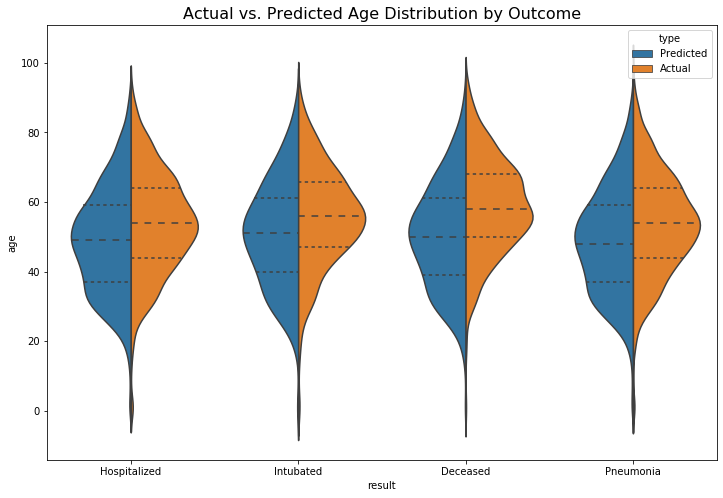

In [147]:
fig, ax = plt.subplots(1,1,figsize=(12,8))
ax = sns.violinplot(x='result',y='age',hue='type',data=agedf,split=True,inner='quartile')
ax.set_title('Actual vs. Predicted Age Distribution by Outcome',fontsize=16)


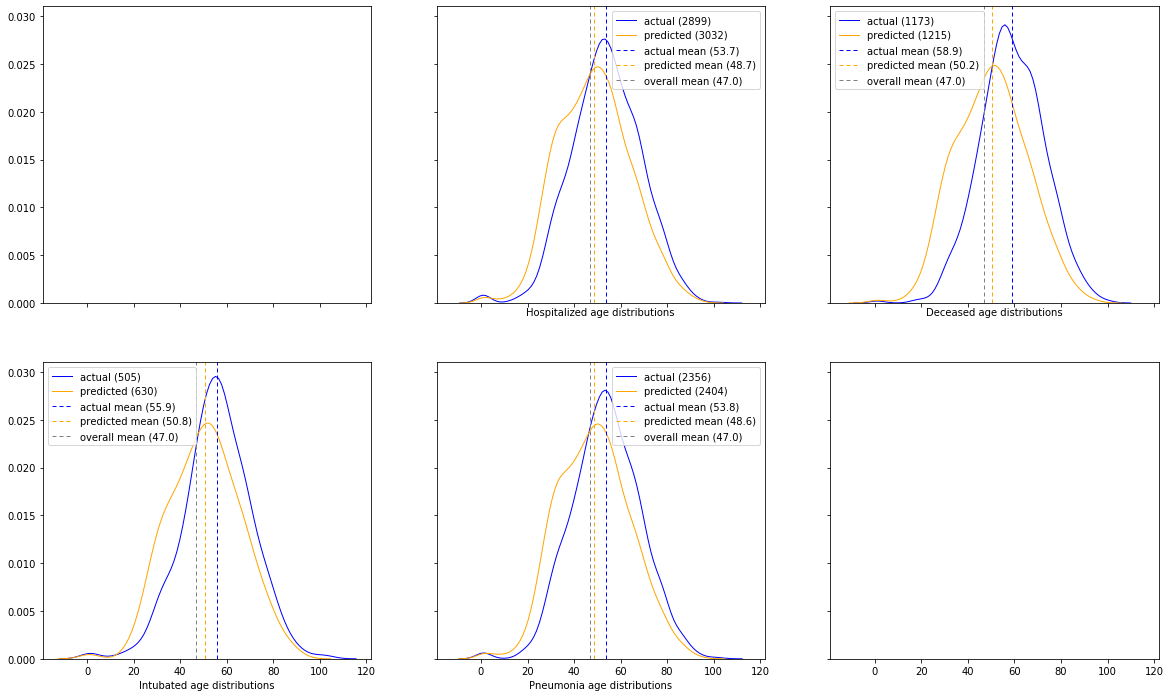

In [134]:
fix, axs = plt.subplots(2,3,figsize=(20,12),sharex=True,sharey=True)
custom_lines = [Line2D([0], [0], color='blue', lw=1),
                Line2D([0], [0], color='orange', lw=1),
                Line2D([0], [0], color='blue', lw=1, dashes=(4.,3.)),
                Line2D([0], [0], color='orange', lw=1, dashes=(4.,3.)),
                Line2D([0], [0], color='grey', lw=1, dashes=(4.,3.))]
for i in range(nclasses):
    sns.distplot(labelstats[classes[i]]['age'], hist = False, kde = True,kde_kws = {'linewidth': 1}
                    ,ax=axs[(nclasses - i)%2,(nclasses - i)%3],axlabel=classes[i]+' age distributions',color='blue')
    sns.distplot(agedistfrompreds[classes[i]], hist = False, kde = True,kde_kws = {'linewidth': 1}
                    ,ax=axs[(nclasses - i)%2,(nclasses - i)%3],color='orange')
    axs[(nclasses - i)%2,(nclasses - i)%3].axvline(x=round(np.mean(flatlblstats['age']),1),color='grey',dashes=(4.,3.),lw=1)
    axs[(nclasses - i)%2,(nclasses - i)%3].axvline(x=round(np.mean(labelstats[classes[i]]['age']),1),color='blue',dashes=(4.,3.),lw=1)
    axs[(nclasses - i)%2,(nclasses - i)%3].axvline(x=round(np.mean(agedistfrompreds[classes[i]]),1),color='orange',dashes=(4.,3.),lw=1)
    axs[(nclasses - i)%2,(nclasses - i)%3].legend(custom_lines,('actual ('+str(len(labelstats[classes[i]]['age']))+')','predicted ('+str(len(agedistfrompreds[classes[i]]))+')'
                                                    ,'actual mean ('+str(round(np.mean(labelstats[classes[i]]['age']),1))+')'
                                                    ,'predicted mean ('+str(round(np.mean(agedistfrompreds[classes[i]]),1))+')'
                                                    ,'overall mean ('+str(round(np.mean(flatlblstats['age']),1))+')'))

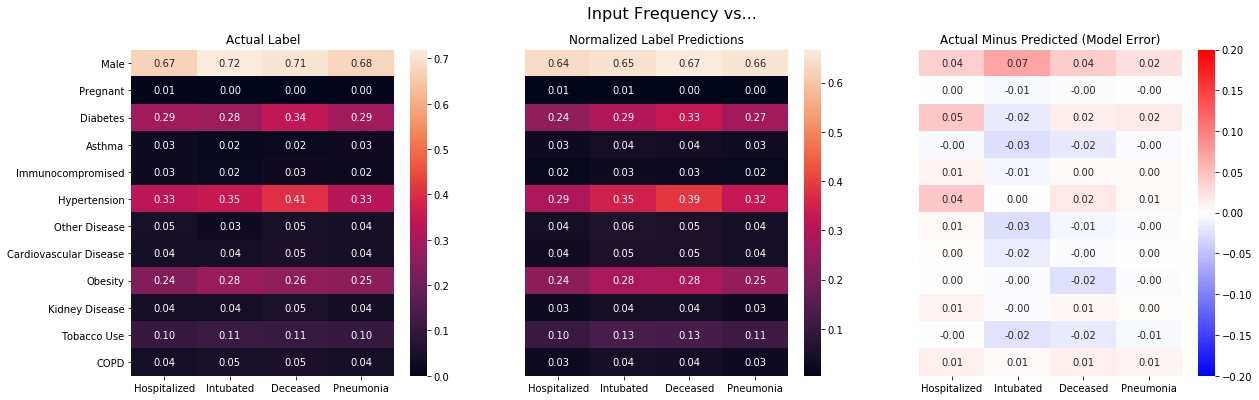

In [44]:
truthcondheatmap = np.zeros((nclasses,ncolumns),dtype=np.float32)
predcondheatmap = np.zeros((ncolumns,nclasses),dtype=np.float32)
for i,trth in enumerate(flatlblstats['truth']):
    for cond in flatlblstats['conditions'][i]:
        for lab in trth:
            truthcondheatmap[classes.index(lab),columns.index(cond)] += 1
        predcondheatmap[columns.index(cond)] += flatlblstats['predprobs'][i]
predcondheatmap = predcondheatmap.T
for i in range(nclasses):
    truthcondheatmap[i] /= len(labelstats[classes[i]]['age'])
    predcondheatmap[i] /= sum(predsbyage[classes[i]])
fig, axs = plt.subplots(1,3,figsize=(20,6))
sns.heatmap(truthcondheatmap.T,ax=axs[0],yticklabels=columns,xticklabels=classes,annot=True,fmt='.2f')
sns.heatmap(predcondheatmap.T,ax=axs[1],yticklabels=False,xticklabels=classes,annot=True,fmt='.2f')
sns.heatmap((truthcondheatmap - predcondheatmap).T,ax=axs[2],yticklabels=False,xticklabels=classes,annot=True,fmt='.2f',cmap='bwr',vmin=-0.2,vmax=0.2)
fig.suptitle('Input Frequency vs...',fontsize=16)
axs[0].title.set_text('Actual Label')
axs[1].title.set_text('Normalized Label Predictions')
axs[2].title.set_text('Actual Minus Predicted (Model Error)')